In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../src')
from data.audio_dataset import AudioSpectrogramDataset
from models.PGAN_model.PGAN import PGAN
from models.PGAN_model.config import *

import torch
import librosa
import soundfile as sf
from torch.utils.data import DataLoader

C:\Users\micha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
dataset = AudioSpectrogramDataset(base_directory=base_directory, spectro_type='mel')
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [4]:
Music_PGAN = PGAN(
    latent_dim=latent_dim,
    output_dim=output_dim,
    lr=learning_rate,
    loss=loss,
    batch_size=batch_size,
    gpu=gpu,
    depths=depths, 
    negative_slope=negative_slope,
    fade_in_percentage=fade_in_percentage,
    save_interval=save_interval,
    normalization=normalization,
    mini_batch_normalization=mini_batch_normalization,
    init_resolution_size=init_resolution_size,
    num_epochs_per_resolution=num_epochs_per_resolution,
)

In [5]:
Music_PGAN.train(dataloader=dataloader)

Resolution 0 - Epoch 1/1000 - D Loss: 0.7828235626220703 - G Loss: 516.7557373046875
Resolution 0 - Epoch 2/1000 - D Loss: 1091.0830078125 - G Loss: 11906.3994140625
Resolution 0 - Epoch 3/1000 - D Loss: 23621.7890625 - G Loss: 6961.5693359375
Resolution 0 - Epoch 4/1000 - D Loss: 14425.6044921875 - G Loss: 215.82310485839844
Resolution 0 - Epoch 5/1000 - D Loss: 423.4019775390625 - G Loss: 8.33703327178955
Resolution 0 - Epoch 6/1000 - D Loss: 12.448336601257324 - G Loss: 7.1768717765808105
Resolution 0 - Epoch 7/1000 - D Loss: 10.427983283996582 - G Loss: 6.13602876663208
Resolution 0 - Epoch 8/1000 - D Loss: 8.653398513793945 - G Loss: 5.221079349517822
Resolution 0 - Epoch 9/1000 - D Loss: 7.125473976135254 - G Loss: 4.424450874328613
Resolution 0 - Epoch 10/1000 - D Loss: 5.8306779861450195 - G Loss: 3.7427494525909424
Resolution 0 - Epoch 11/1000 - D Loss: 4.744034767150879 - G Loss: 3.1566765308380127
Resolution 0 - Epoch 12/1000 - D Loss: 3.8463640213012695 - G Loss: 2.66662240

In [6]:
checkpoint_path = "../src/models/PGAN_model/checkpoints/PGAN_checkpoint_res1_epoch4.pth"
Music_PGAN.train(dataloader=dataloader, checkpoint_path=checkpoint_path)

Resuming training from epoch 4 at resolution 1
Resolution 1 - Epoch 5/10 - D Loss: 0.26160770654678345 - G Loss: 0.7603479027748108
Resolution 1 - Epoch 6/10 - D Loss: 0.2303144931793213 - G Loss: 0.5080401301383972
Checkpoint saved: c:\0. Studia\0. Praca inzynierska\Music_Samples_Generator\src\models\PGAN_model\checkpoints\PGAN_checkpoint_res1_epoch6.pth
Resolution 1 - Epoch 7/10 - D Loss: 0.24150323867797852 - G Loss: 0.6541447043418884
Resolution 1 - Epoch 8/10 - D Loss: 0.2676298916339874 - G Loss: 0.8865568041801453
Checkpoint saved: c:\0. Studia\0. Praca inzynierska\Music_Samples_Generator\src\models\PGAN_model\checkpoints\PGAN_checkpoint_res1_epoch8.pth
Resolution 1 - Epoch 9/10 - D Loss: 0.203263521194458 - G Loss: 0.6860917806625366
Resolution 1 - Epoch 10/10 - D Loss: 0.23728398978710175 - G Loss: 0.6139963269233704
Checkpoint saved: c:\0. Studia\0. Praca inzynierska\Music_Samples_Generator\src\models\PGAN_model\checkpoints\PGAN_checkpoint_res1_epoch10.pth
Resolution 2 - Epoc

In [6]:
Music_PGAN.close_all_writers()

In [6]:
Music_PGAN.save_full_model("PGAN")

Full model saved: c:\0. Studia\0. Praca inzynierska\Music_Samples_Generator\src\models\PGAN_model\../../../models/saved_models/PGAN/PGAN


In [7]:
Music_PGAN.generator.eval()

PGenerator(
  (blocks): ModuleList(
    (0): ModuleList(
      (0): Sequential(
        (0): Upsample(scale_factor=2.0, mode=nearest)
        (1): ConvTranspose2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (2): LeakyReLU(negative_slope=0.2)
      )
      (1): Sequential(
        (0): ConvTranspose2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.2)
      )
      (2): Sequential(
        (0): Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
      )
    )
    (1): ModuleList(
      (0): Sequential(
        (0): Upsample(scale_factor=2.0, mode=nearest)
        (1): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (2): LeakyReLU(negative_slope=0.2)
      )
      (1): Sequential(
        (0): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.2)
      )
      (2): Sequential(
        (0): Conv2d(128, 1, kernel_

In [8]:
z = torch.randn(1, Music_PGAN.latent_dim).to(Music_PGAN.device)
generated_spectrogram = Music_PGAN.generator(z)

In [10]:
spectrogram = generated_spectrogram.cpu().detach().numpy()
print(spectrogram.shape)
spectrogram = spectrogram.squeeze()
print(spectrogram.shape)

(1, 1, 256, 160)
(256, 160)


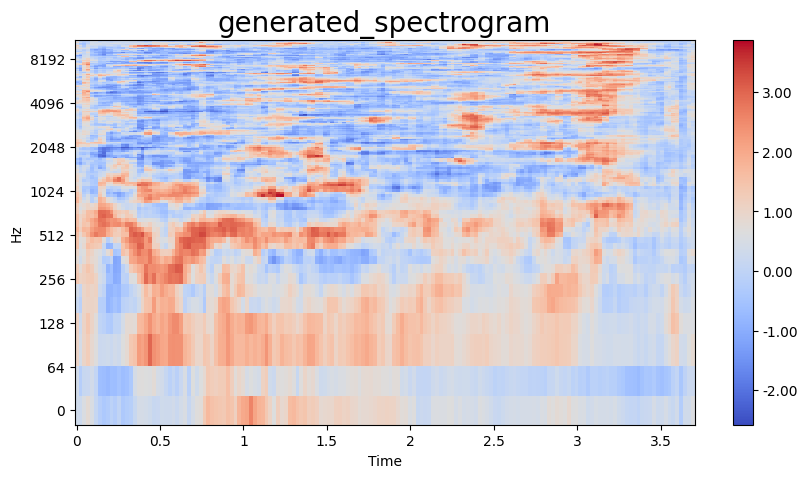

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

img = librosa.display.specshow(spectrogram, x_axis='time', y_axis='log')
plt.title('generated_spectrogram', fontsize=20)
plt.colorbar(img, format='%0.2f')

plt.show()

In [11]:
audio = librosa.feature.inverse.mel_to_audio(spectrogram)

path = '../models/generated_samples/'
file_name = 'PGAN_generated_audio.wav'

sf.write(path + file_name, audio, 22050)